In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from tqdm import tqdm

/home/zhdano82/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%run train_nf.py --alpha 1. --start_id 199000 --in_shape 128 16 --n_samples 200000 --n_layers 3 --train 0 --n_channels 32 --n_epochs 10 --data_path '/bigdata/hplsim/aipp/Maksim/BA_simulation/layer_3/'

100%|██████████| 50/50 [00:01<00:00, 29.13it/s]



 Data loaders created
Surrogate model pre-trained


In [25]:
flow.load_state_dict(torch.load('./saved_models/0_05_10_100_4_100__flow'))
enc.load_state_dict(torch.load('./saved_models/0_05_10_100_4_100__enc'))

<All keys matched successfully>

In [26]:
xs, ys = next(iter(loaders['train']))
x_pred = model(ys.cuda()).squeeze().cpu().detach()

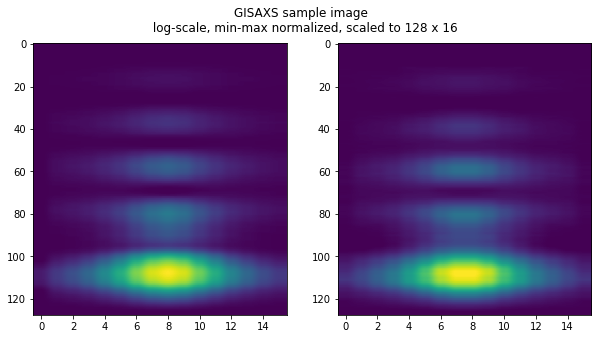

In [27]:
fig, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].imshow(xs[0], aspect = 'auto', vmin = 0, vmax = 1)
ax[1].imshow(x_pred[0], aspect = 'auto', vmin = 0, vmax = 1)
plt.suptitle('GISAXS sample image \n log-scale, min-max normalized, scaled to 128 x 16')
plt.show()

## Density estimation

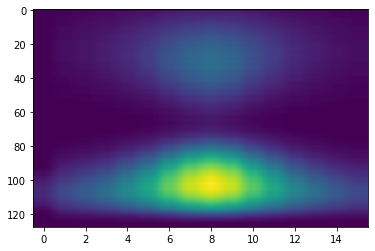

In [28]:
x_t, y_t = loaders['val'].dataset[0]
plt.imshow(x_t, aspect = 'auto')

In [29]:
x = x_t.cuda().unsqueeze(0)
y = y_t.cuda().unsqueeze(0)
optimizer.zero_grad()
x_enc = enc(x.unsqueeze(1))

In [30]:
x_enc = x_enc[0,:].unsqueeze(0) #0-th element in the batch
y_gt = y[0].reshape(3,2,3).cpu().detach().numpy() #0-th element in the batch
y_sampled = flow.sample(10000, x_enc).squeeze().cpu().detach()

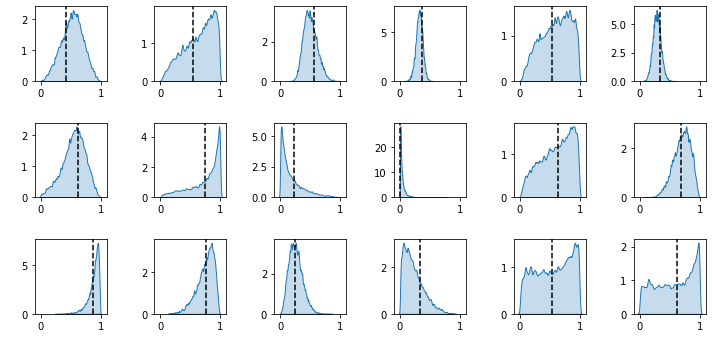

In [31]:
fig, ax = plt.subplots(3,6,figsize = [10,5])

for i in range(3):
    for j in range(6):
        sns.kdeplot(y_sampled.reshape(-1,3,6)[:,i,j], fill=True, bw_adjust=0.25, label = 'Surrogate model', ax = ax[i,j]);
        ax[i,j].axvline(x=y_t.reshape(3,6)[i,j], color='k', linestyle='--', label = 'true value')
        ax[i,j].set_xlim(-0.1,1.1)
        ax[i,j].set_xlabel(' ')
        ax[i,j].set_ylabel(' ')
        
fig.tight_layout()
plt.show()

In [22]:
y_m_ = []
diff_m = []
eps = 3e-2

def generator():
    while len(y_m_) < 1000:
        yield
        
pbar = tqdm(generator())
for _ in pbar:
    y = torch.rand([10000,18])
    x_m = model(y.unsqueeze(0).cuda()).cpu().detach()
    mae = (x_m.squeeze() - x_t.unsqueeze(0)).abs().mean((1,2))
    y_eps = y[mae < eps]
    if len(y_eps):
        y_m_.append(np.array(y_eps))
    pbar.set_postfix({'num_elements': len(y_m_)})

23640it [33:17, 11.83it/s, num_elements=725]


KeyboardInterrupt: 

In [23]:
y_m_ = np.concatenate(y_m_)

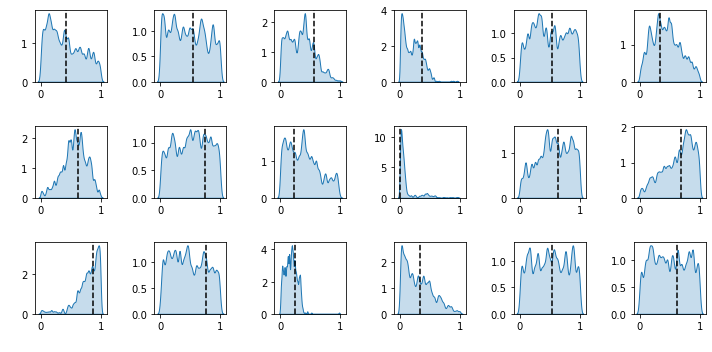

In [24]:
fig, ax = plt.subplots(3,6,figsize = [10,5])

for i in range(3):
    for j in range(6):
        sns.kdeplot(y_m_.reshape(-1,3,6)[:,i,j], fill=True, bw_adjust=0.25, label = 'Surrogate model', ax = ax[i,j]);
        ax[i,j].axvline(x=y_t.reshape(3,6)[i,j], color='k', linestyle='--', label = 'true value')
        ax[i,j].set_xlim(-0.1,1.1)
        ax[i,j].set_xlabel(' ')
        ax[i,j].set_ylabel(' ')
        
fig.tight_layout()
plt.show()

In [ ]:
j = 0 # layer id

fig, ax = plt.subplots(2,3,figsize = [30,10])
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')

for i in range(2):
    for k in range(3):
        parameter = cols[i][k]
        sns.kdeplot(np.array(y_sampled.reshape(-1,3,2,3))[:,j,i,k], fill=True, bw_adjust=0.5, ax = ax[i,k]);
        ax[i,k].axvline(x=y_gt[j,i,k], color='k', linestyle='--', label = 'true value')
        ax[i,k].set_xlim(0,1)
fig.tight_layout()